Paper link: http://snap.stanford.edu/class/cs224w-2017/projects/cs224w-11-final.pdf

In [1]:
import numpy as np
import geopandas as gpd
import networkx as nx

In [2]:
from shapely.geometry import shape

In [12]:
import geopandas as gpd
import json
import os

file_path = os.path.join('data', 'london_lsoa.json')

with open(file_path) as f:
    geo_json = json.load(f)['features']
    for g in geo_json:
        g['geometry'] = shape(g['geometry'])
        for k, v in g['properties'].items():
            g[k] = v

# open file
df = gpd.GeoDataFrame(geo_json)

df.drop(['type', 'properties'], inplace=True, axis=1)

df.head()

,geometry,msoa_code,msoa_name,la_code,la_name,geoeast,geonorth,popeast,popnorth,area_km2,MOVEMENT_ID,DISPLAY_NAME
0,"MULTIPOLYGON (((-0.47794 51.55485, -0.47665 51...",E02000508,Hillingdon 015,00AS,Hillingdon,506163,183536,505978,183811,2.74660,0,"Hillingdon, 00AS (0)"
1,"MULTIPOLYGON (((0.05255 51.56171, 0.05310 51.5...",E02000716,Newham 003,00BB,Newham,541978,186009,541870,185568,1.56517,1,"Newham, 00BB (1)"
2,"MULTIPOLYGON (((0.01001 51.52181, 0.01003 51.5...",E02000747,Newham 034,00BB,Newham,539578,181317,539891,181438,2.08241,2,"Newham, 00BB (2)"
3,"MULTIPOLYGON (((0.05392 51.51611, 0.05174 51.5...",E02000748,Newham 035,00BB,Newham,542500,181152,542439,181339,1.33175,3,"Newham, 00BB (3)"
4,"MULTIPOLYGON (((0.03241 51.51704, 0.03179 51.5...",E02000749,Newham 036,00BB,Newham,541047,181103,540847,181294,1.41902,4,"Newham, 00BB (4)"


In [13]:
df['centroid'] = df.geometry.apply(lambda x: x.centroid)

In [14]:
from sklearn.metrics.pairwise import haversine_distances

In [15]:
adjacency_dict = dict()

for _, row in df.iterrows():
    row_id = row.MOVEMENT_ID
    row_centroid = row.centroid
    # Get 'not disjoint' locations
    neighbors = df[(~df.geometry.disjoint(row.geometry)) & (df.MOVEMENT_ID != row_id)]

    # Remove own ID of the place from the list
    #neighbors = [n for n in neighbors if row_id != n.MOVEMENT_ID]

    neighbor_ids = neighbors.MOVEMENT_ID.tolist()
    neighbor_centroids = neighbors.centroid.tolist()

    # Add adjacency dict entry
    adjacency_dict[row_id] = { n: {'weight': haversine_distances([[row_centroid.x, row_centroid.y],[c.x, c.y]])[0,1]}
                              for n, c in zip(neighbor_ids, neighbor_centroids) }

In [16]:
spatial_network = nx.from_dict_of_dicts(adjacency_dict)

In [17]:
spatial_network.nodes()

NodeView(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '

In [18]:
nx.is_directed(spatial_network)

False

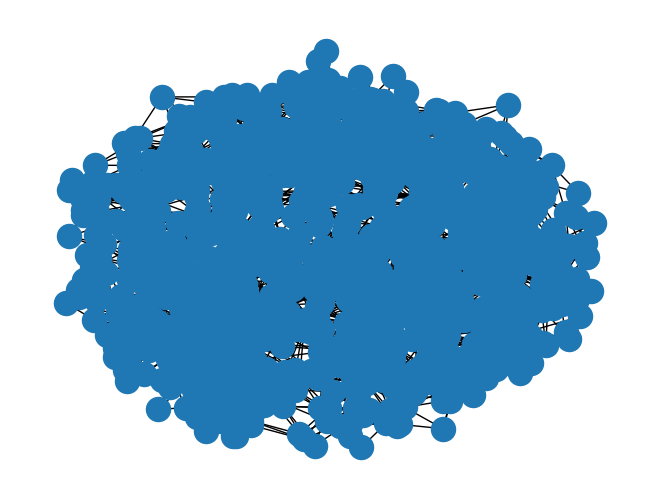

In [19]:
nx.draw(spatial_network)

In [20]:
import matplotlib.pyplot as plt

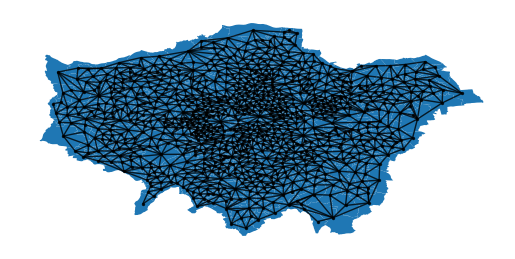

In [21]:
fig, ax = plt.subplots(1, 1)

df.plot(ax=ax)


coordinates = dict()
for i, r in df.iterrows():
    coordinates[r.MOVEMENT_ID] = (r.centroid.x, r.centroid.y)

nx.draw(
    spatial_network,
    coordinates,
    ax=ax,
    node_size=2,
    node_color="k",
    edge_color="k",
    alpha=0.8,
)
plt.show()